# SLAM Final Project

Victoria Park Dataset (for more information such as vehicle modeling, dynamic model and measurement model see [link](https://www-personal.acfr.usyd.edu.au/nebot/victoria_park.htm).)

**DATASET** - *arranged in time-order*

Example of the dataset (note that gps is gt, it is not used for EFK but used only for evaluation):

     | data[0] =  ('gps', [time, zx_gt, zy_gt, ztheta_gt])
     | data[1] =  ('odometry', [time, ve, alpha])
     | data[2] =  ('odometry', [time, ve, alpha])
     | data[3] =  ('measurements', [time, d0, phi0, d1, phi1, ...])
     | data[4] =  ('odometry', [time, ve, alpha])
     | data[5] =  ('odometry', [time, ve, alpha])
     | data[6] =  ('gps', [time, zx_gt, zy_gt, ztheta_gt])
     | data[7] =  ('odometry', [time, ve, alpha])
     | data[8] =  ('odometry', [time, ve, alpha])
     | data[9] =  ('measurements', [time, d0, phi0, d1, phi1, ...])
     ...

# TODO

**1. data.npy**

*   Assume that all landmarks are static
*   Implement EKF SLAM

<img src = "https://drive.google.com/uc?id=1ELl2QZ3D_-_LSzbHLD6l_Qs5LJ10i_jI" height = 500>

\

**2. data_dynamic.npy**

*   Assume that all the trees are going crazy, uprooting themselves and moving at a velocity of [0.05, 0.05].
*   Trees are starting to move from the beginning of the data (starts to move right after data[0])
*   Implement EKF SLAM with consideration of these dynamic landmarks.

\

* **EX) with common EKF SLAM (left), with EKF SLAM for dynamic landmarks (right)**

<img src = "https://drive.google.com/uc?id=1E_EzqCIchZcV1O6YSE5rU_5LHXOIpbEA" width = 400>
<img src = "https://drive.google.com/uc?id=1EL75ntOpKoOvzH88XnT5yt-j-KFrrMQ5" width = 400>

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.distributions import chi2
from tqdm.auto import tqdm

In [9]:
def solve_cost_matrix_heuristic(M):
    n_msmts = M.shape[0]
    result = []

    ordering = np.argsort(M.min(axis=1))

    for msmt in ordering:
        match = np.argmin(M[msmt,:])
        M[:, match] = 1e8
        result.append((msmt, match))

    return result

def compute_data_association(MU, SIGMA, num_of_seen_landmarks, measurements, R):
    def measurement_model(MU, landmark_id):
        z_x, z_y, z_theta = MU[:robot_dim]
        z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))
        m_x, m_y = MU[robot_dim + landmark_dim*landmark_id : robot_dim + landmark_dim*(landmark_id+1)]
        d = np.sqrt((m_x-z_x)**2 + (m_y-z_y)**2)
        phi = np.arctan2((m_y-z_y),(m_x-z_x)) - z_theta
        phi = np.arctan2(np.sin(phi), np.cos(phi))
        zhat = np.array([d, phi])

        H = np.zeros((2,MU.size))
        H[0,0] = -(m_x - z_x)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,0] = (m_y - z_y)/((m_x - z_x)**2+(m_y - z_y)**2)
        H[0,1] = -(m_y - z_y)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,1] = -(m_x - z_x)/((m_x - z_x)**2+(m_y - z_y)**2)
        H[0,2] = 0
        H[1,2] = -1
        H[0,1+2*(landmark_id+1)] = (m_x - z_x)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,1+2*(landmark_id+1)] = -(m_y - z_y)/((m_x-z_x)**2+(m_y-z_y)**2)
        H[0,2+2*(landmark_id+1)] = (m_y - z_y)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,2+2*(landmark_id+1)] = (m_x-z_x)/((m_x-z_x)**2+(m_y-z_y)**2)

        return zhat, H

    if num_of_seen_landmarks == 0:
        # set association to init new landmarks for all measurements
        return np.array([-1 for m in measurements])

    A = np.full((len(measurements),len(measurements)),chi2.ppf(0.96, df=2))
    cost_mat = np.full((len(measurements), num_of_seen_landmarks), chi2.ppf(0.96, df=2))

    for k in range(0,len(measurements)):
        for j in range(0,num_of_seen_landmarks):
            z_hat,H = measurement_model(MU, j)
            # print(measurements[k][0:2])
            r = np.array(np.array(measurements[k][0:2]) - np.array(z_hat))
            S_inv = np.linalg.inv(np.matmul(np.matmul(H,SIGMA),np.transpose(H)) + R[:2,:2])
            MD = np.matmul(np.matmul(np.transpose(r),S_inv), r)
            cost_mat[k,j] = MD

    cost_mat_conc = np.concatenate((cost_mat, A), axis=1)
    temp1 = np.copy(cost_mat)
    results = solve_cost_matrix_heuristic(temp1)

    assoc = np.zeros(len(measurements),dtype = np.int32)
    for k in range(0, len(results)):
        # print(cost_mat[results[k][0],results[k][1]])
        if cost_mat_conc[results[k][0],results[k][1]] > chi2.ppf(0.99, df=2):
            assoc[results[k][0]] = -1
        elif cost_mat_conc[results[k][0],results[k][1]] >= chi2.ppf(0.95, df=2):
            assoc[results[k][0]] = -2
        else:
            assoc[results[k][0]] = results[k][1]

    return assoc

def cal_ate_rmse(state_history, gps_history, optim=False):
    state_history = np.array(state_history)
    state_history_t = state_history[:,0]

    max_dt = 0.015 # [s]    0.015
    ATE_errors = []
    # associated idxs
    idxs_gps = []
    idxs_est = []

    for i, gps in enumerate(gps_history):
        gps_t = gps[0]
        gps_xy = gps[1:3]

        # associate
        associated_idx = np.argmin(np.abs(state_history_t - gps_t))

        if np.abs(state_history_t[associated_idx] - gps_t) < max_dt:
            est_xy = state_history[associated_idx][1:3]
            ATE_error = (gps_xy[0] - est_xy[0])**2 + (gps_xy[1] - est_xy[1])**2
            ATE_errors.append(ATE_error)
            idxs_est.append(associated_idx)
            idxs_gps.append(i)

    ATE_errors = np.array(ATE_errors)
    ATE_RMSE = np.sqrt(np.mean(ATE_errors))
    if not optim:
        print(f"ATE RMSE: {ATE_RMSE:.3f}[m]")
    return ATE_RMSE, idxs_gps, idxs_est

In [10]:
# parameters
robot_dim = 3
landmark_dim = 2
num_of_total_landmarks = 200 # assumed to be known

vehicle_params = {
        "a": 3.78,
        "b": 0.50,
        "L": 2.83,
        "H": 0.76
    }

In [11]:
def g_dynamic(z, u, dT, vehicle_params):

  #print('State before: ', z)
  z_new = z.copy()
  z_theta = z_new[2]
  z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))  # normalize angle

  a = vehicle_params['a']
  b = vehicle_params['b']
  L = vehicle_params['L']
  H = vehicle_params['H']

  ve = u[0]
  alpha = u[1]
  vc = ve/(1 - np.tan(alpha)*H/L)

  dyn_model = np.array([
    dT * (vc * np.cos(z_theta) - vc / L * np.tan(alpha) * (a * np.sin(z_theta) + b * np.cos(z_theta))),
    dT * (vc * np.sin(z_theta) + vc / L * np.tan(alpha) * (a * np.cos(z_theta) - b * np.sin(z_theta))),
    dT * vc / L * np.tan(alpha)
    ])

  z_new[:3] += dyn_model
  
  return z_new

def g_jacobian(z, u, dT, vehicle_params):

  z_theta = z[2]
  z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))

  a = vehicle_params['a']
  b = vehicle_params['b']
  L = vehicle_params['L']
  H = vehicle_params['H']

  ve = u[0]
  alpha = u[1]
  vc = ve/(1 - np.tan(alpha)*H/L)

  G13 = -dT*vc*(np.sin(z_theta)+(1/L)*np.tan(alpha)*(a*np.cos(z_theta)-b*np.sin(z_theta)))
  G23 = dT*vc*(np.cos(z_theta)-(1/L)*np.tan(alpha)*(a*np.sin(z_theta)+b*np.cos(z_theta)))
  g_jacob = np.array([[1, 0, G13], [0, 1, G23],[0, 0, 1]])
  return g_jacob

def h_measurement(z, landmark_index, h_measurement_out):
  z_x = z[0]
  z_y = z[1]
  z_theta = z[2]
  z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))

  m_x = z[robot_dim + landmark_dim*landmark_index]
  m_y = z[robot_dim + landmark_dim*landmark_index + 1]

  del_x = m_x - z_x
  del_y = m_y - z_y
  r = del_x**2 + del_y**2
  sqrt_r = np.sqrt(r)
  new_theta = np.arctan2(del_y,del_x)-z_theta
  new_theta = np.arctan2(np.sin(new_theta), np.cos(new_theta))
  zhat = [[sqrt_r],[new_theta]]

  h_measurement_out[0] = zhat[0]
  h_measurement_out[1] = zhat[1]

  return h_measurement_out

def h_jacobian(z, landmark_index):

  z_x = z[0]
  z_y = z[1]

  m_x = z[robot_dim + landmark_dim*landmark_index]
  m_y = z[robot_dim + landmark_dim*landmark_index + 1]

  del_x = m_x - z_x
  del_y = m_y - z_y
  r = del_x**2 + del_y**2
  sqrt_r = np.sqrt(r)

  h = np.array([[-sqrt_r*del_x, -sqrt_r*del_y, 0, sqrt_r*del_x, sqrt_r*del_y],[del_y, -del_x, -r, -del_y, del_x]])/r
  F_x = np.zeros((5, len(z)))
  F_x[:3,:3] = np.eye(3)
  F_x[3,3+2*landmark_index]=1
  F_x[4,4+2*landmark_index]=1
  h_jacob = np.matmul(h,F_x)

  return h_jacob

In [ ]:
# Dynamic noise
Q = np.diag(np.append(np.array([0.0303356**2, # variance of robot x
                                0.0918367**2, # variance of robot y
                                0.0211368**2]), # variance of robot theta
                                np.zeros((landmark_dim * num_of_total_landmarks,))))

# Measurement noise
R = np.diag([0.6385455**2, (0.0456069)**2])

  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 1.392[m]
num_trees 182


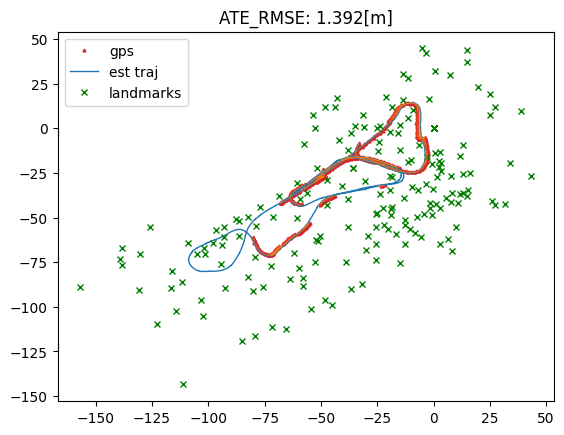

In [ ]:
###########################################################################
# main
###########################################################################
# Reading dataset
# events, robot_init_pose = read_data(len_data=10000, path=your_data_path)

events, robot_init_pose = np.load('../data/data_dynamic.npy', allow_pickle=True)

'''
  it takes about 10 minuts for all trajectory estimation.
  for debuging you can crop the events as the following:
'''
#events = events[:5000] #

time_prev = -1
gps_history = []
state_history = {
    'robot_pose_history': [],
    'x': np.array(robot_init_pose),
    'P': np.array([.1, .1, 1])
}

# MU, SIGMA
MU = np.append(robot_init_pose, np.zeros((landmark_dim * num_of_total_landmarks, )))
SIGMA = np.diag(np.append(1 * np.ones((robot_dim, )), 100 * np.ones((landmark_dim * num_of_total_landmarks, ))))
num_of_seen_landmarks = 0

for i, event in tqdm(enumerate(events), total=len(events)):
  time_curr = event[1][0]

  if event[0] == 'odometry':
    ## For the first data
    if time_prev < 0:
      time_prev = time_curr
      continue
    ##

    # Dynamic Update
    u = event[1][1:]    # u_t = [ve, alpha]
    dT = time_curr - time_prev
    MU = g_dynamic(MU, u, dT, vehicle_params)
    g_jacob = g_jacobian(MU, u, dT, vehicle_params)
    SIGMA[0:3, 0:3] = g_jacob @ SIGMA[0:3, 0:3] @ g_jacob.T + Q[0:3, 0:3]

    time_prev = time_curr
    #current_txy = [event[1][0], ekf_state['x'][0], ekf_state['x'][1]]

  elif event[0] == 'measurements':
    # measurements of the currently seen landmarks from current scan: (range, angle, diameter)
    x_list_curr = np.reshape(event[1][1:], [-1,3])

    # find data association informations
    # associations[i] ==  j if measurement i is associated with landmark j,
    # associations[i] == -1 if measurement i is determined to be a new, previously unseen landmark, or,
    # associations[i] == -2 if measurement i is too ambiguous to use and should be discarded.
    associations = compute_data_association(MU, SIGMA, num_of_seen_landmarks, x_list_curr, R)

    # update the measurements x, update the landmark indices, and update the states of the newly seen landmarks
    for x_curr, association in zip(x_list_curr, associations):
      z_x, z_y, z_theta = MU[0:3]
      d, phi, _ = x_curr # _, d, phi = x_curr
      if association == -2: # Outlier, ignore it
        continue
      elif association== -1: # new landmark
        # update x
        m_x = z_x + d*np.cos(z_theta + phi)
        m_y = z_y + d*np.sin(z_theta + phi)
        MU[robot_dim + landmark_dim * num_of_seen_landmarks] += m_x
        MU[robot_dim + landmark_dim * num_of_seen_landmarks + 1] += m_y
        num_of_seen_landmarks += 1
        #continue
      else:
        predicted_z = h_measurement(MU, association, np.zeros((2, 1)))
        h_measurement_out = np.zeros((2, 1))
        h_measurement_out = h_measurement(MU, association, h_measurement_out)
        h_jacob = h_jacobian(MU, association)

        K = SIGMA @ h_jacob.T @ np.linalg.inv(h_jacob @ SIGMA @ h_jacob.T + R)
        MU = MU + (K @ (np.array([[d], [phi]]) - h_measurement_out)).flatten()
        SIGMA = SIGMA - K @ h_jacob @ SIGMA

  elif event[0] == 'gps':
    gps_history.append(event[1][:3])
    continue

  state_history['x'] = np.vstack((state_history['x'], MU[0:3]))
  #print('State history:', state_history['x'][-1])
  state_history['P'] = np.vstack((state_history['P'], np.diag(SIGMA[:3,:3])))
  state_history['robot_pose_history'].append([time_prev, MU[0], MU[1]])

# end of data
ATE_RMSE, idxs_gps, idxs_est = cal_ate_rmse(state_history['robot_pose_history'], gps_history)

# plot results
plt.cla()
plt.rcParams['figure.figsize'] = [10, 10]
## GPS
gps_history = np.array(gps_history)
plt.plot(gps_history[:,1], gps_history[:,2], '^', markersize=2, color='tab:red', label='gps')
## Estimated Traj
plt.plot(state_history['x'][:,0], state_history['x'][:,1], color='tab:blue', linewidth=1, label='est traj')
## Landmarks
trees_plot = np.array(MU[3:]).reshape(-1,2)
plt.plot(trees_plot[:,0], trees_plot[:,1], 'xg', markersize=4, label='landmarks')

## Optional, to check associations between est traj and gps datas
for i in range(len(idxs_gps)):
  plt.plot(   [state_history['x'][idxs_est[i],0], gps_history[idxs_gps[i],1]],\
              [state_history['x'][idxs_est[i],1], gps_history[idxs_gps[i],2]],\
              color='tab:orange', linewidth=0.3)

print("num_trees", num_of_seen_landmarks)

plt.title(f"ATE_RMSE: {ATE_RMSE:.3f}[m]")
plt.legend()
plt.show()

# Bayesian Optimization

In [12]:
def run_ekf_slam(Q, R):
  
  events, robot_init_pose = np.load('../data/data_dynamic.npy', allow_pickle=True)

  '''
    it takes about 10 minuts for all trajectory estimation.
    for debuging you can crop the events as the following:
  '''
  #events = events[:5000] #

  time_prev = -1
  gps_history = []
  state_history = {
      'robot_pose_history': [],
      'x': np.array(robot_init_pose),
      'P': np.array([.1, .1, 1])
  }

  # MU, SIGMA
  MU = np.append(robot_init_pose, np.zeros((landmark_dim * num_of_total_landmarks, )))
  SIGMA = np.diag(np.append(1 * np.ones((robot_dim, )),
                            100 * np.ones((landmark_dim * num_of_total_landmarks, ))))
  chunk_size = 50  # number of landmarks to allocate per chunk
  allocated_landmarks = num_of_total_landmarks  # Track current allocation

  num_of_seen_landmarks = 0

  for i, event in tqdm(enumerate(events), total=len(events)):
    time_curr = event[1][0]

    if event[0] == 'odometry':
      ## For the first data
      if time_prev < 0:
        time_prev = time_curr
        continue
      ##

      # Dynamic Update
      u = event[1][1:]    # u_t = [ve, alpha]
      dT = time_curr - time_prev
      MU = g_dynamic(MU, u, dT, vehicle_params)
      g_jacob = g_jacobian(MU, u, dT, vehicle_params)
      SIGMA[0:3, 0:3] = g_jacob @ SIGMA[0:3, 0:3] @ g_jacob.T + Q[0:3, 0:3]

      time_prev = time_curr
      #current_txy = [event[1][0], ekf_state['x'][0], ekf_state['x'][1]]

    elif event[0] == 'measurements':
      # measurements of the currently seen landmarks from current scan: (range, angle, diameter)
      x_list_curr = np.reshape(event[1][1:], [-1,3])

      # find data association informations
      # associations[i] ==  j if measurement i is associated with landmark j,
      # associations[i] == -1 if measurement i is determined to be a new, previously unseen landmark, or,
      # associations[i] == -2 if measurement i is too ambiguous to use and should be discarded.
      associations = compute_data_association(MU, SIGMA, num_of_seen_landmarks, x_list_curr, R)

      # update the measurements x, update the landmark indices, and update the states of the newly seen landmarks
      for x_curr, association in zip(x_list_curr, associations):
        z_x, z_y, z_theta = MU[0:3]
        d, phi, _ = x_curr 
        if association == -2: # Outlier, ignore it
          continue
        elif association== -1: # new landmark
          # Check if we need more space
          if num_of_seen_landmarks >= allocated_landmarks:
            # Expand by one chunk
            additional_space = landmark_dim * chunk_size
            
            # Expand MU and SIGMA
            MU = np.append(MU, np.zeros((additional_space,)))

            # Expand SIGMA
            SIGMA = np.pad(SIGMA, ((0, additional_space), (0, additional_space)), mode='constant', constant_values=0)

            # Set diagonal values of SIGMA for the new landmarks to 100
            new_landmark_indices = np.arange(robot_dim + landmark_dim * allocated_landmarks,
                                            robot_dim + landmark_dim * allocated_landmarks + additional_space)

            SIGMA[new_landmark_indices, new_landmark_indices] = 100.0
            allocated_landmarks += chunk_size
          
          # new landmark, init landmark state
          m_x = z_x + d*np.cos(z_theta + phi)
          m_y = z_y + d*np.sin(z_theta + phi)
          MU[robot_dim + landmark_dim * num_of_seen_landmarks] += m_x
          MU[robot_dim + landmark_dim * num_of_seen_landmarks + 1] += m_y
          num_of_seen_landmarks += 1
          #continue
        else:
          h_measurement_out = np.zeros((2, 1))
          h_measurement_out = h_measurement(MU, association, h_measurement_out)
          h_jacob = h_jacobian(MU, association)

          K = SIGMA @ h_jacob.T @ np.linalg.inv(h_jacob @ SIGMA @ h_jacob.T + R)
          MU = MU + (K @ (np.array([[d], [phi]]) - h_measurement_out)).flatten()
          SIGMA = SIGMA - K @ h_jacob @ SIGMA

    elif event[0] == 'gps':
      gps_history.append(event[1][:3])
      continue

    state_history['x'] = np.vstack((state_history['x'], MU[0:3]))
    #print('State history:', state_history['x'][-1])
    state_history['P'] = np.vstack((state_history['P'], np.diag(SIGMA[:3,:3])))
    state_history['robot_pose_history'].append([time_prev, MU[0], MU[1]])

  # end of data
  ATE_RMSE, idxs_gps, idxs_est = cal_ate_rmse(state_history['robot_pose_history'], gps_history, optim=True)

  output_dir = "../ekf_slam_stat_with_dyn_landmarks"
  os.makedirs(output_dir, exist_ok=True)

  # Plot results
  plt.cla()
  plt.rcParams['figure.figsize'] = [10, 10]

  # GPS trajectory
  gps_history = np.array(gps_history)
  plt.plot(gps_history[:,1], gps_history[:,2], '^', markersize=2, color='tab:red', label='gps')

  # Estimated robot trajectory
  plt.plot(state_history['x'][:,0], state_history['x'][:,1], color='tab:blue', linewidth=1, label='est traj')

  # Landmarks
  trees_plot = np.array(MU[3:]).reshape(-1,2)
  plt.plot(trees_plot[:,0], trees_plot[:,1], 'xg', markersize=4, label='landmarks')

  # Optionally show GPS vs estimated association lines
  for i in range(len(idxs_gps)):
    plt.plot([state_history['x'][idxs_est[i],0], gps_history[idxs_gps[i],1]],
            [state_history['x'][idxs_est[i],1], gps_history[idxs_gps[i],2]],
            color='tab:orange', linewidth=0.3)

  # Title includes RMSE and number of landmarks
  plt.title(f"ATE_RMSE: {ATE_RMSE:.3f} [m] | Seen Landmarks: {num_of_seen_landmarks}")
  plt.legend()

  # Save the figure
  filename = f"slam_result_rmse_{ATE_RMSE:.3f}_landmarks_{num_of_seen_landmarks}.png"
  save_path = os.path.join(output_dir, filename)
  plt.savefig(save_path, dpi=200)
  plt.close()
  
  return ATE_RMSE, num_of_seen_landmarks

## Static Optimization using dynamic Landmarks

In [13]:
import pandas as pd
from bayes_opt import BayesianOptimization

def run_slam_with_params(q_x, q_y, q_theta, r_range, r_bearing):
    # Construct Q and R
    robot_noise = np.array([q_x**2, q_y**2, q_theta**2])
    landmark_noise = np.zeros(landmark_dim * num_of_total_landmarks)
    full_noise = np.append(robot_noise, landmark_noise)
    Q = np.diag(full_noise)
    R = np.diag([r_range**2, r_bearing**2])

    # Run EKF SLAM
    ATE_RMSE, num_seen_landmarks = run_ekf_slam(Q, R)
    print(f"ATE RMSE: {ATE_RMSE:.4f}, Seen landmarks: {num_seen_landmarks}")

    # Record all parameters and results
    run_metadata.append({
        'X': q_x,
        'Y': q_y,
        'Theta': q_theta,
        'Range': r_range,
        'Bearing': r_bearing,
        'ATE_MSRE': ATE_RMSE,
        'Num_Landmarks': num_seen_landmarks
    })

    # Scoring strategy
    MAX_ALLOWED_LANDMARKS = 200
    PENALTY_SCALE = 1
    alpha = 0.5

    effective_landmark_score = min(num_seen_landmarks, MAX_ALLOWED_LANDMARKS) / MAX_ALLOWED_LANDMARKS
    penalty = 0
    if num_seen_landmarks > MAX_ALLOWED_LANDMARKS:
        excess = num_seen_landmarks - MAX_ALLOWED_LANDMARKS
        penalty = (excess / PENALTY_SCALE) ** 2

    score = -ATE_RMSE + alpha * effective_landmark_score - penalty
    return score

run_metadata = []

# Bounds for optimization
pbounds = {
    'q_x': (0.001, 0.1),
    'q_y': (0.001, 0.1),
    'q_theta': (np.radians(0.1), np.radians(2)),
    'r_range': (0.1, 1.0),
    'r_bearing': (np.radians(0.5), np.radians(10))
}

# Optimizer
optimizer = BayesianOptimization(
    f=run_slam_with_params,
    pbounds=pbounds,
    random_state=42,
)

# Run optimization
optimizer.maximize(init_points=8, n_iter=30)

# Print best result
print("Best parameters found:")
print(optimizer.max)

# Identify best metadata
best_index = np.argmax([res['target'] for res in optimizer.res])
best_meta = run_metadata[best_index]
print(f"Best ATE RMSE: {best_meta['ATE_MSRE']:.4f}")
print(f"Best Seen Landmarks: {best_meta['Num_Landmarks']}")

# Save to CSV
df = pd.DataFrame(run_metadata)
filename_slam_opt = "../results/slam_stat_opt_with_dyn_landmarks.csv"
df.to_csv(filename_slam_opt, index=False, columns=[
    'X', 'Y', 'Theta', 'Range', 'Bearing', 'ATE_MSRE', 'Num_Landmarks'
])


|   iter    |  target   |    q_x    |    q_y    |  q_theta  |  r_range  | r_bearing |
-------------------------------------------------------------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.0661, Seen landmarks: 177
| 2         | -8.623573 | 0.0380794 | 0.0951207 | 0.0260191 | 0.6387926 | 0.0345955 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 46.6192, Seen landmarks: 193
| 3         | -46.13670 | 0.0164434 | 0.0067502 | 0.0304688 | 0.6410035 | 0.1261295 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 111.8601, Seen landmarks: 378
| 4         | -31795.36 | 0.0030378 | 0.0970210 | 0.0293501 | 0.2911051 | 0.0388743 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 41.0080, Seen landmarks: 195
| 5         | -40.52054 | 0.0191570 | 0.0311199 | 0.0191469 | 0.4887505 | 0.0570142 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 38.1552, Seen landmarks: 268
| 6         | -4661.655 | 0.0615734 | 0.0148098 | 0.0114332 | 0.4297256 | 0.0843459 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.8084, Seen landmarks: 189
| 7         | -9.335892 | 0.0787324 | 0.0207677 | 0.0187979 | 0.6331731 | 0.0164284 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 220.0085, Seen landmarks: 244
| 8         | -2155.508 | 0.0611469 | 0.0178818 | 0.0039025 | 0.9539969 | 0.1688345 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 33.8148, Seen landmarks: 181
| 9         | -33.36228 | 0.0810313 | 0.0311567 | 0.0049842 | 0.7158097 | 0.0817066 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 8.1265, Seen landmarks: 195
| 10        | -7.638958 | 0.0665897 | 0.0623157 | 0.0302002 | 0.6720480 | 0.1661189 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 55.8358, Seen landmarks: 267
| 11        | -4544.335 | 0.001     | 0.1       | 0.0349065 | 1.0       | 0.0087266 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 41.4964, Seen landmarks: 209
| 12        | -121.9964 | 0.1       | 0.001     | 0.0017453 | 0.5367955 | 0.1745329 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 108.7953, Seen landmarks: 191
| 13        | -108.3178 | 0.0180613 | 0.0923493 | 0.0157719 | 0.7415603 | 0.1050877 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.4084, Seen landmarks: 150
| 14        | -9.033396 | 0.0378860 | 0.0724080 | 0.0262829 | 0.7356647 | 0.1399623 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 174.1556, Seen landmarks: 346
| 15        | -21489.65 | 0.1       | 0.001     | 0.0349065 | 0.8735920 | 0.0087266 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 8.7927, Seen landmarks: 153
| 16        | -8.410181 | 0.0920344 | 0.0491727 | 0.0318098 | 0.6839309 | 0.1098300 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 53.8213, Seen landmarks: 208
| 17        | -117.3212 | 0.001     | 0.1       | 0.0017453 | 1.0       | 0.1745329 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 40.6639, Seen landmarks: 193
| 18        | -40.18135 | 0.0353980 | 0.0457750 | 0.0090251 | 0.8369932 | 0.0418336 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 10.8477, Seen landmarks: 270
| 19        | -4910.347 | 0.0247456 | 0.0387304 | 0.0241167 | 0.1844883 | 0.1657823 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 356.7689, Seen landmarks: 320
| 20        | -14756.26 | 0.001     | 0.1       | 0.0017453 | 0.8611195 | 0.1745329 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 48.7960, Seen landmarks: 202
| 21        | -52.29602 | 0.0125489 | 0.0911709 | 0.0018428 | 0.5851551 | 0.1203714 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 11.3961, Seen landmarks: 180
| 22        | -10.94614 | 0.0626018 | 0.0625074 | 0.0292187 | 0.6748266 | 0.1637527 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 7.3871, Seen landmarks: 237
| 23        | -1375.887 | 0.0641147 | 0.0815348 | 0.0084148 | 0.2406343 | 0.1134880 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 67.3086, Seen landmarks: 535
| 24        | -112291.8 | 0.001     | 0.0389876 | 0.0017453 | 0.7447099 | 0.0087266 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 8.9378, Seen landmarks: 190
| 25        | -8.462774 | 0.0926724 | 0.0955625 | 0.0223893 | 0.5509641 | 0.0330346 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 8.7013, Seen landmarks: 172
| 26        | -8.271322 | 0.0778932 | 0.0289905 | 0.0099772 | 0.5814209 | 0.0913199 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 92.7031, Seen landmarks: 291
| 27        | -8373.203 | 0.0051851 | 0.0567604 | 0.0349065 | 0.5668229 | 0.0265691 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 14.5498, Seen landmarks: 173
| 28        | -14.11729 | 0.0249932 | 0.0729827 | 0.0017453 | 0.9092614 | 0.0662873 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 67.1098, Seen landmarks: 194
| 29        | -66.62476 | 0.0785128 | 0.0275287 | 0.0329622 | 0.4564686 | 0.0680971 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.0181, Seen landmarks: 159
| 30        | -8.620575 | 0.1       | 0.0863754 | 0.0041760 | 0.8141847 | 0.1038751 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.5228, Seen landmarks: 155
| 31        | -9.135290 | 0.0844472 | 0.0979266 | 0.0349065 | 0.5085661 | 0.1395433 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 48.0651, Seen landmarks: 225
| 32        | -672.5650 | 0.001     | 0.0163726 | 0.0349065 | 0.5275121 | 0.1669634 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 22.2827, Seen landmarks: 199
| 33        | -21.78523 | 0.1       | 0.001     | 0.0017453 | 0.7583368 | 0.1598618 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.0388, Seen landmarks: 166
| 34        | -8.623820 | 0.0761569 | 0.0548961 | 0.0145626 | 0.9500316 | 0.0613065 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.5530, Seen landmarks: 138
| 35        | -9.208047 | 0.1       | 0.1       | 0.0349065 | 1.0       | 0.1370712 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 131.1665, Seen landmarks: 316
| 36        | -13586.66 | 0.001     | 0.1       | 0.0017453 | 0.4605387 | 0.1745329 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 8.9897, Seen landmarks: 171
| 37        | -8.562231 | 0.1       | 0.1       | 0.0017453 | 0.6278438 | 0.0858235 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 116.8959, Seen landmarks: 356
| 38        | -24452.39 | 0.001     | 0.0014182 | 0.0017453 | 1.0       | 0.0904661 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 63.7380, Seen landmarks: 228
| 39        | -847.2380 | 0.0631608 | 0.0088232 | 0.0017453 | 0.8543461 | 0.1194507 |
Best parameters found:
{'target': np.float64(-7.638958125972299), 'params': {'q_x': np.float64(0.06658970615104422), 'q_y': np.float64(0.0623157792876936), 'q_theta': np.float64(0.03020027569102718), 'r_range': np.float64(0.6720480968906528), 'r_bearing': np.float64(0.16611894129280982)}}
Best ATE RMSE: 8.1265
Best Seen Landmarks: 195
